# 计算流体力学 作业5
> 2100011025 王奕博

在本次作业中，我采用涡量流函数法进行方腔流动的求解，并采用边界条件$u(x)=16x^2(1-x)^2$来消除边角上的涡量的奇性。此外，我还采用平凡边界条件$u(x)=1$计算方腔流动，进行对比。

以下是迭代中用到的一些函数：

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# 从速度场计算涡量函数
def v_to_w(u, v, dx, dy):
    w = np.zeros_like(u)
    w[1:-1, 1:-1] = (v[1:-1, 2:] - v[1:-1, :-2]) / (2*dx) - \
        (u[2:, 1:-1] - u[:-2, 1:-1]) / (2*dy)
    return w

# 从涡量函数得到流函数，通过Jacobi迭代解Poisson方程得到。
def w_to_phi(w, dx, dy, tol):
    psi = np.zeros_like(w)
    change = 1.0
    times = 0
    while change > tol:
        psi_new = psi.copy()
        psi_new[1:-1, 1:-1] = (w[1:-1, 1:-1] + (psi[2:, 1:-1] + psi[:-2, 1:-1]) / (dy**2)
                               + (psi[1:-1, 2:] + psi[1:-1, :-2]) / (dx**2)) / (2 / (dx**2)+2 / (dy**2))
        change = np.max(np.abs(psi_new - psi))
        psi = psi_new
        times += 1
        if times >= 10000:
            break
    return psi

# 应用涡量场的边界条件，实现了Thom条件和Woods条件
def boundary_w(w, u, v, psi, dx, dy, method="Thom", uxx=None):
    if method == "Thom":
        w_new = w.copy()
        w_new[:, 0] = 2 / (dx**2) * (psi[:, 0] - psi[:, 1]) - 2 / dx * v[:, 0]
        w_new[:, -1] = 2 / (dx**2) * (psi[:, -1] -
                                      psi[:, -2]) + 2 / dx * v[:, -1]
        w_new[0, :] = 2 / (dy**2) * (psi[0, :] - psi[1, :]) + 2 / dy * u[0, :]
        w_new[-1, :] = 2 / (dy**2) * (psi[-1, :] -
                                      psi[-2, :]) - 2 / dy * u[-1, :]
    elif method == "Woods":
        w_new = w.copy()
        w_new[:, 0] = -w[:, 1]/2 - 3*(psi[:, 1] - psi[:, 0]) / \
            (dx*dx) - 3 * v[:, 0] / dx
        w_new[:, -1] = -w[:, -2]/2 - 3 * \
            (psi[:, -2] - psi[:, -1])/(dx*dx) - 3 * v[:, -1]/dx
        w_new[0, :] = -w[1, :]/2 - 3*(psi[1, :] - psi[0, :]) / \
            (dy*dy) - 3 * u[0, :]/dy + dy * uxx[0, :]/2
        w_new[-1, :] = -w[-1, :]/2 - 3 * \
            (psi[-2, :] - psi[-1, :])/(dy*dy) - 3 * u[-1, :]/dy
    return w_new

# 通过中心格式，计算涡量的时间导数，并更新涡量
def next_w(w, psi, dx, dy, dt, nu):
    w_next = w.copy()
    uw_x = -(psi[2:, 1:-1] - psi[:-2, 1:-1]) * \
        (w[1:-1, 2:] - w[1:-1, :-2]) / (4*dx*dy)
    vw_y = (psi[1:-1, 2:] - psi[1:-1, :-2]) * \
        (w[2:, 1:-1] - w[:-2, 1:-1]) / (4*dx*dy)
    ddw_y = (w[2:, 1:-1] + w[:-2, 1:-1] - 2 * w[1:-1, 1:-1]) / (dy**2)
    ddw_x = (w[1:-1, 2:] + w[1:-1, :-2] - 2 * w[1:-1, 1:-1]) / (dx**2)
    w_next[1:-1, 1:-1] = w[1:-1, 1:-1] + dt * \
        (uw_x + vw_y + nu * ddw_y + nu * ddw_x)
    return w_next

# 由流函数得到速度场
def psi_to_v(psi, u, v, dx, dy):
    u_new = u.copy()
    v_new = v.copy()
    u_new[1:-1, 1:-1] = (psi[2:, 1:-1]-psi[:-2, 1:-1]) / (2*dy)
    v_new[1:-1, 1:-1] = -(psi[1:-1, 2:]-psi[1:-1, :-2]) / (2*dx)
    u_scalar = np.sqrt(u_new**2 + v_new**2)
    return u_new, v_new, u_scalar

# 画图，包括速度大小热力图、流函数等高线图（流线图）以及速度场的流场图
def paint(ux, uy, u, psi, x, y, name: str):
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(u, cmap='viridis',
               interpolation='nearest')
    plt.xticks(np.linspace(0, u.shape[0]-1,
               num=5), np.linspace(0.0, 1.0, num=5))
    plt.yticks(np.linspace(0, u.shape[1]-1,
               num=5), np.linspace(0.0, 1.0, num=5))
    plt.colorbar()

    plt.subplot(1, 3, 2)
    levels = np.linspace(np.min(psi), np.max(psi), 20)
    plt.contour(x, y, psi, cmap='viridis', linewidths=0.8, levels=levels)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.gca().set_aspect(1)

    plt.subplot(1, 3, 3)
    plt.streamplot(x, y, ux, uy, linewidth=0.8)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.gca().set_aspect(1)

    plt.suptitle(name)
    plt.show()

# 画出水平中线上的竖直速度分布图和竖直中线上的水平速度分布图
def paint_velo(ux, uy, name):
    ux_mid = ux[:, 50]
    uy_mid = uy[50, :]
    x1 = np.linspace(0, 1, len(ux_mid))
    x2 = np.linspace(0, 1, len(uy_mid))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    ax1.plot(x1, ux_mid)
    ax1.set_title('horizonal mid-line velocity')
    ax1.set_xlabel('X')
    ax1.set_ylabel(r'u_x')
    ax2.plot(x2, uy_mid)
    ax2.set_title('vertical mid-line velocity')
    ax2.set_xlabel('Y')
    ax2.set_ylabel(r'u_y')
    plt.tight_layout()
    fig.suptitle(name)
    plt.show()

以下是程序的主要流程：

1000


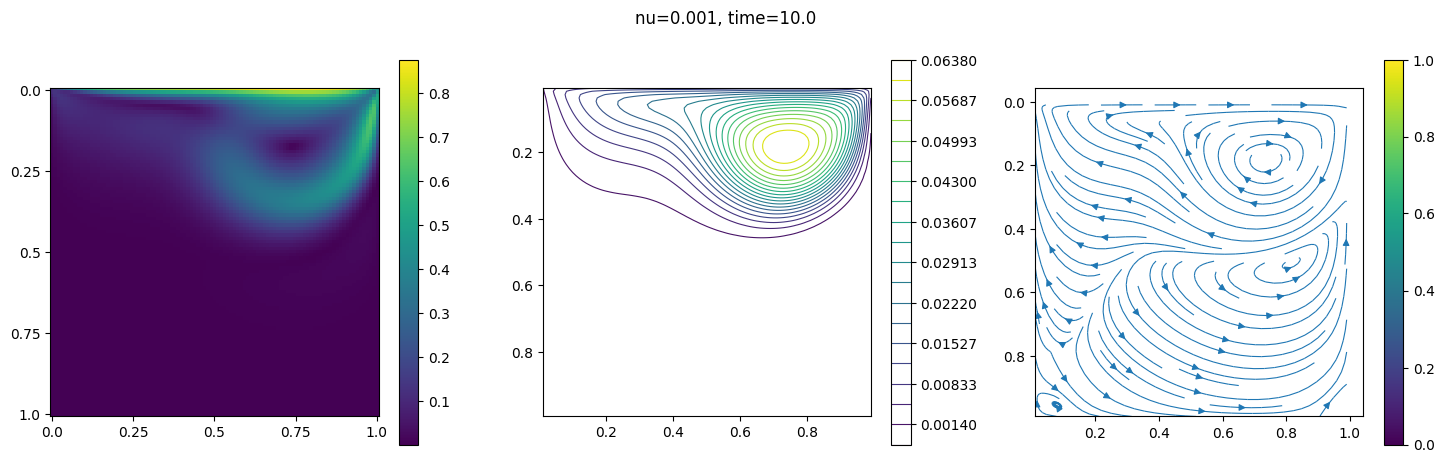

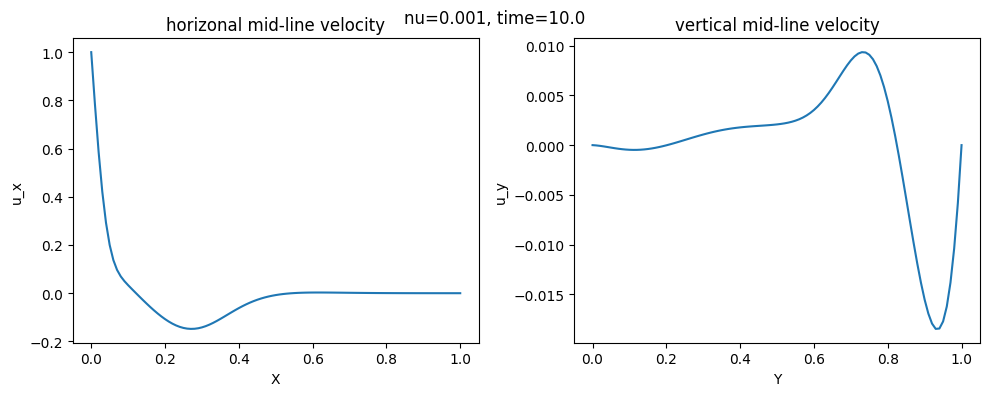

2000


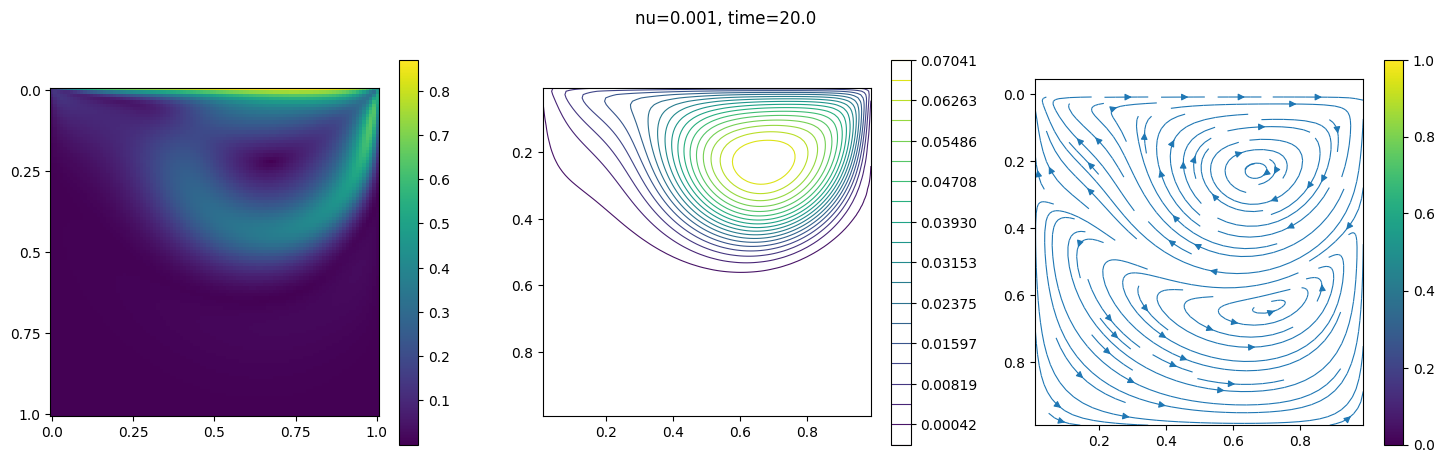

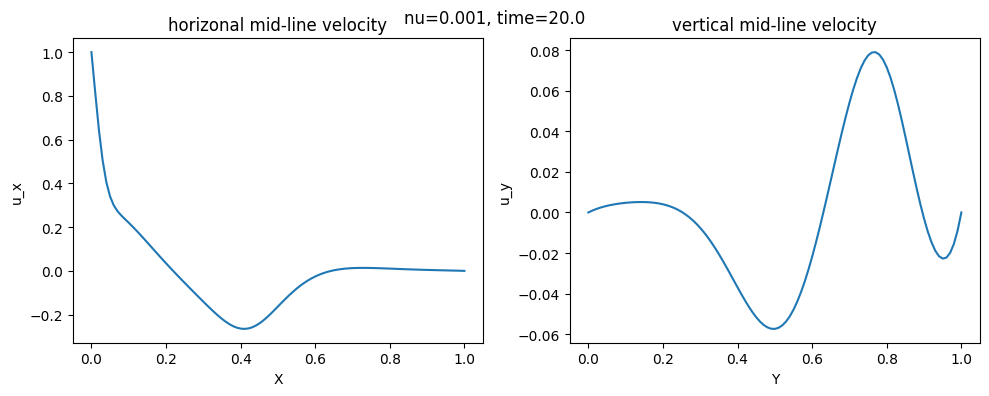

3000


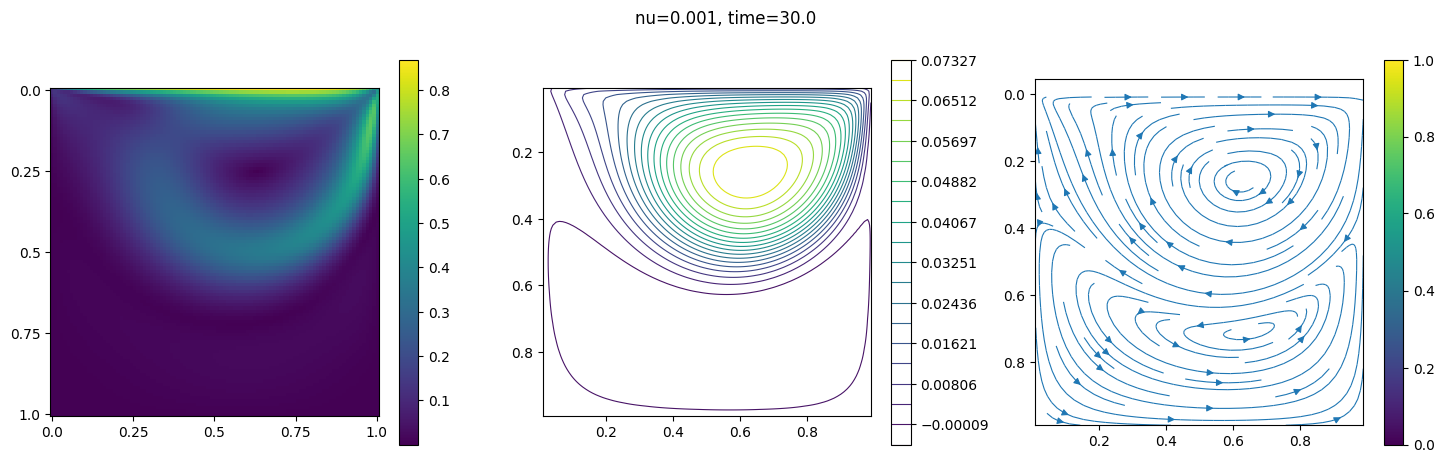

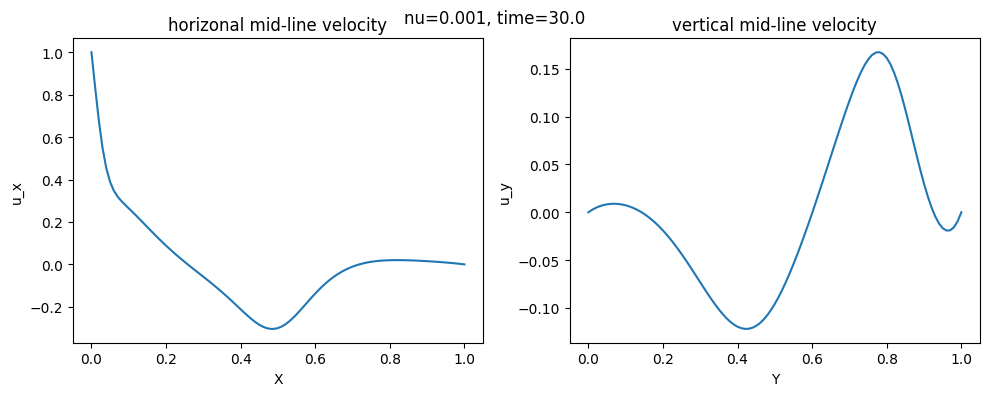

4000


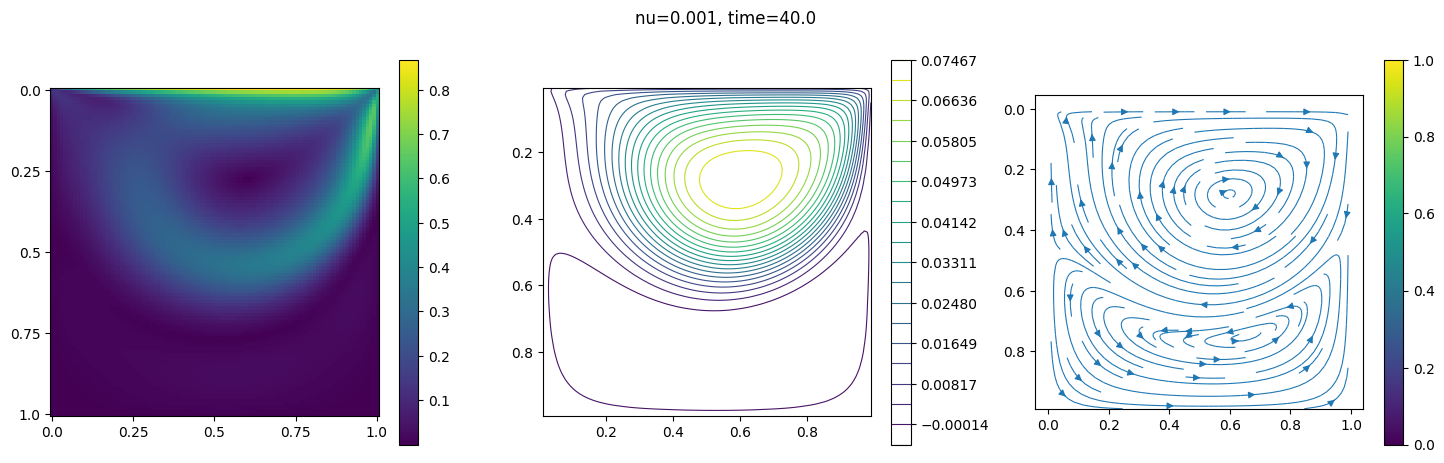

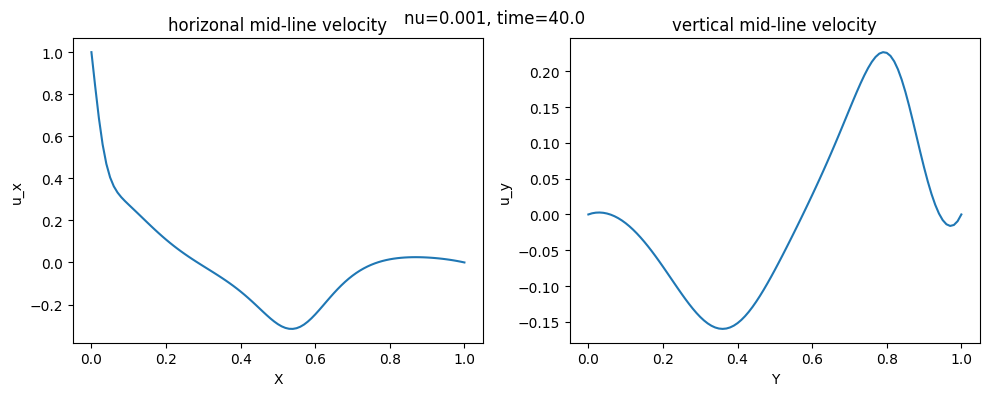

5000


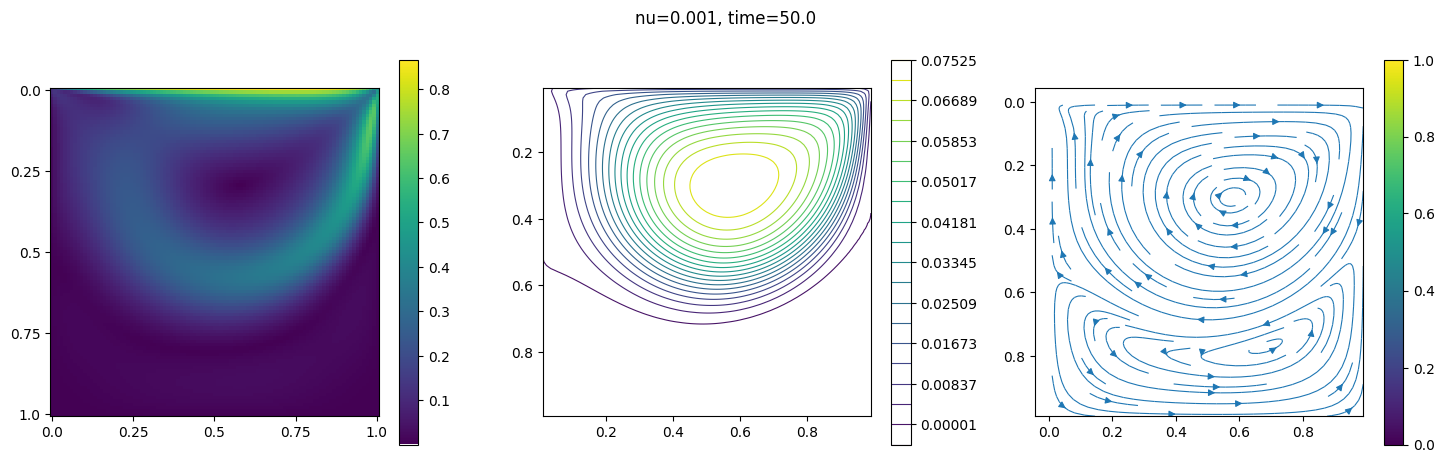

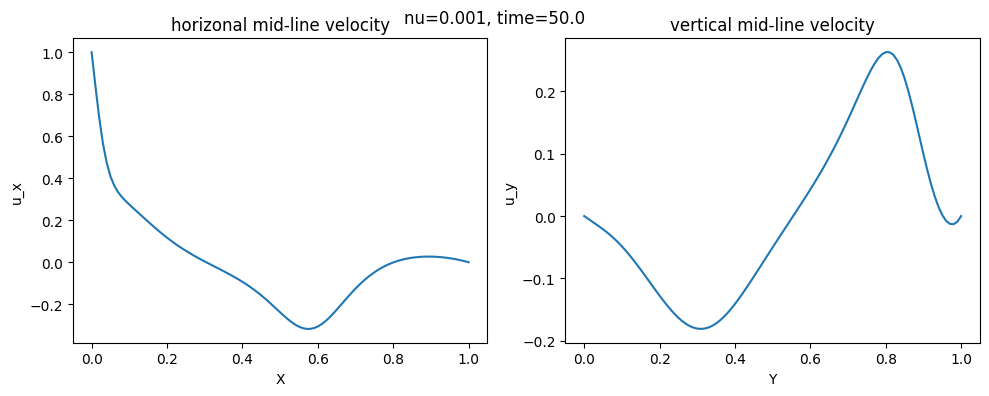

6000


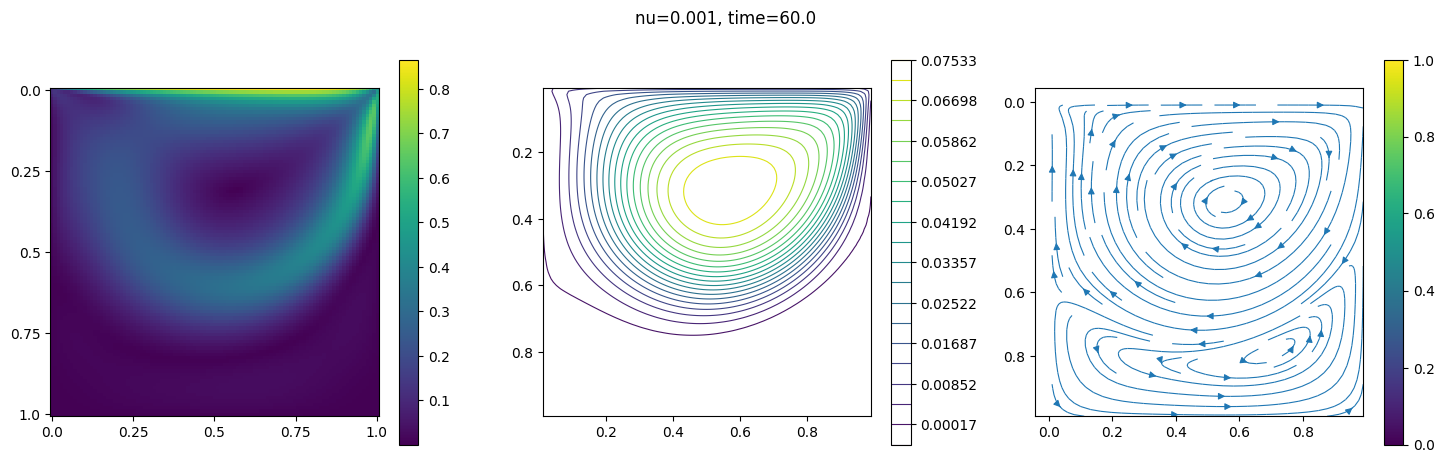

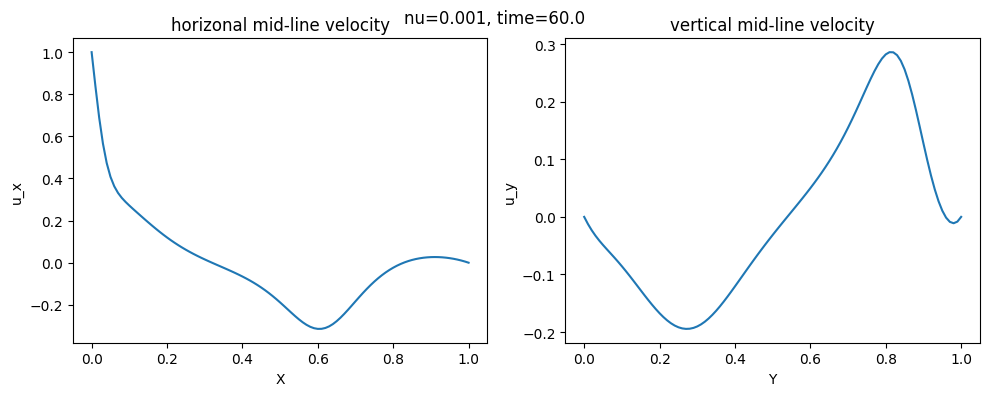

7000


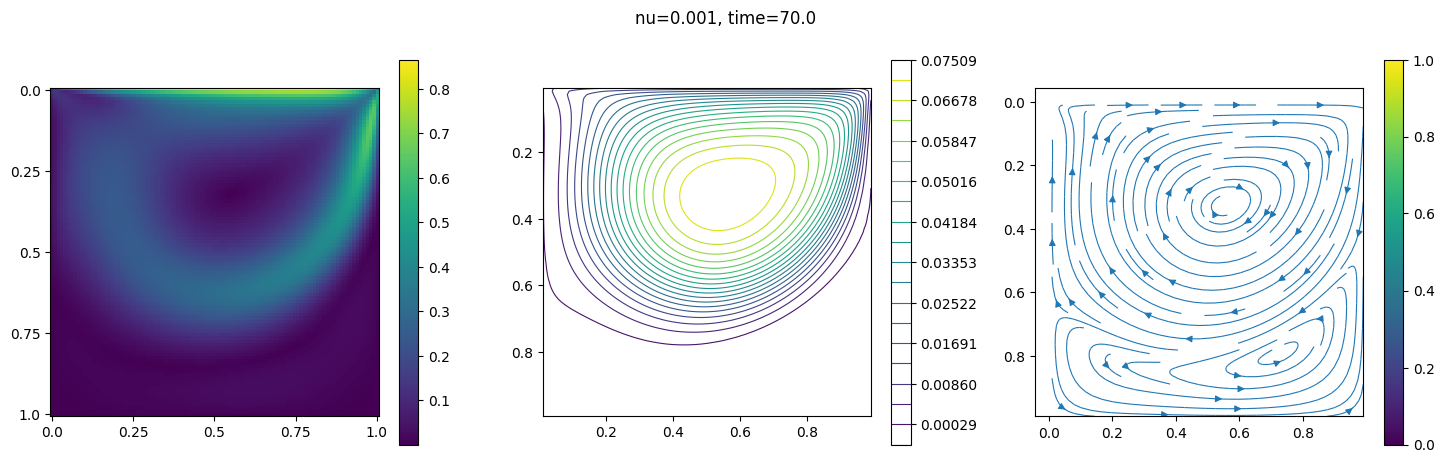

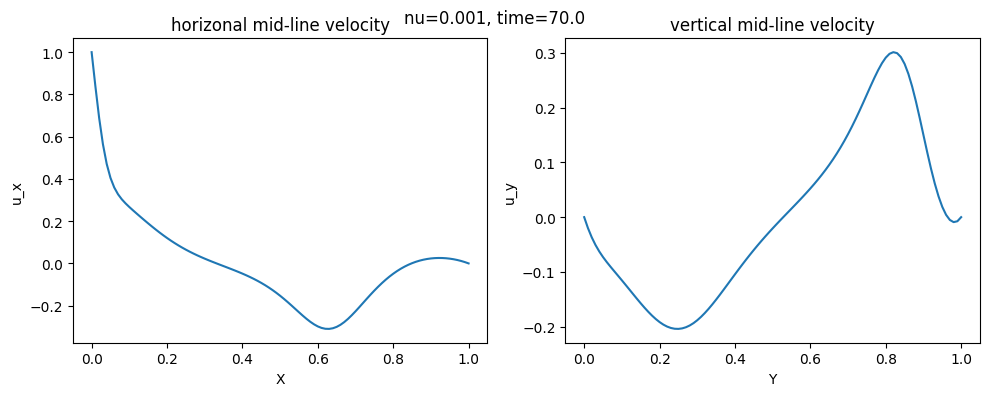

8000


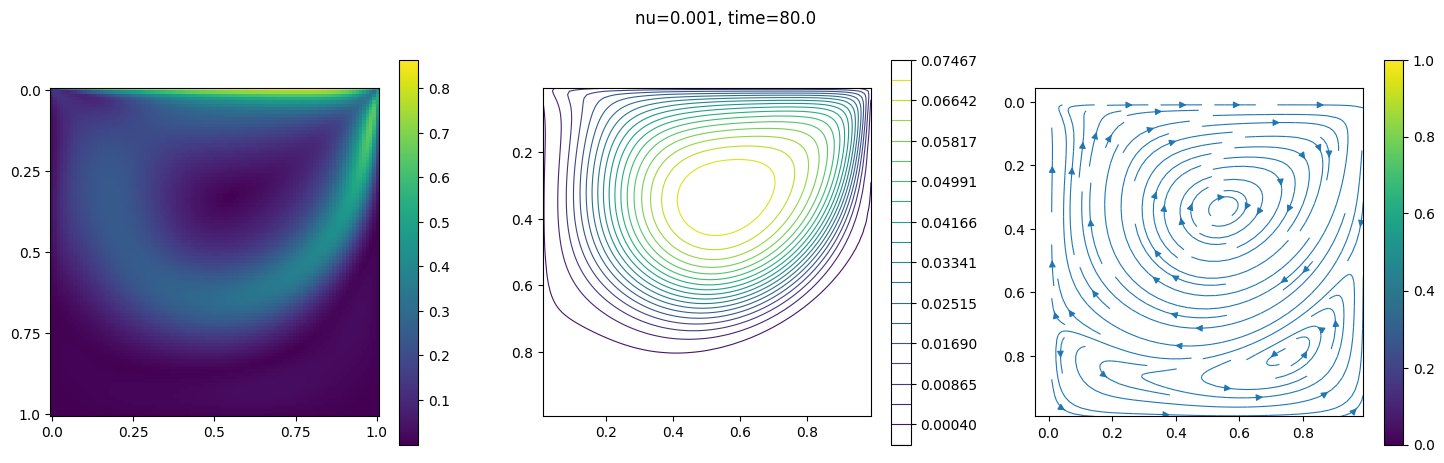

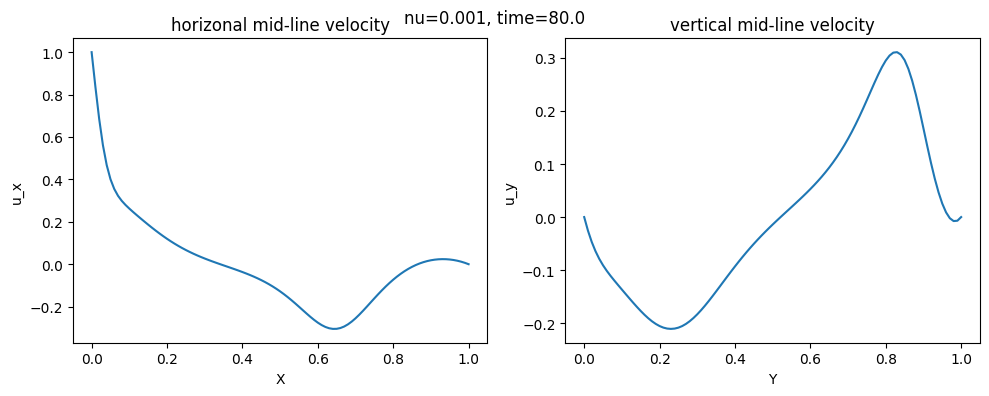

9000


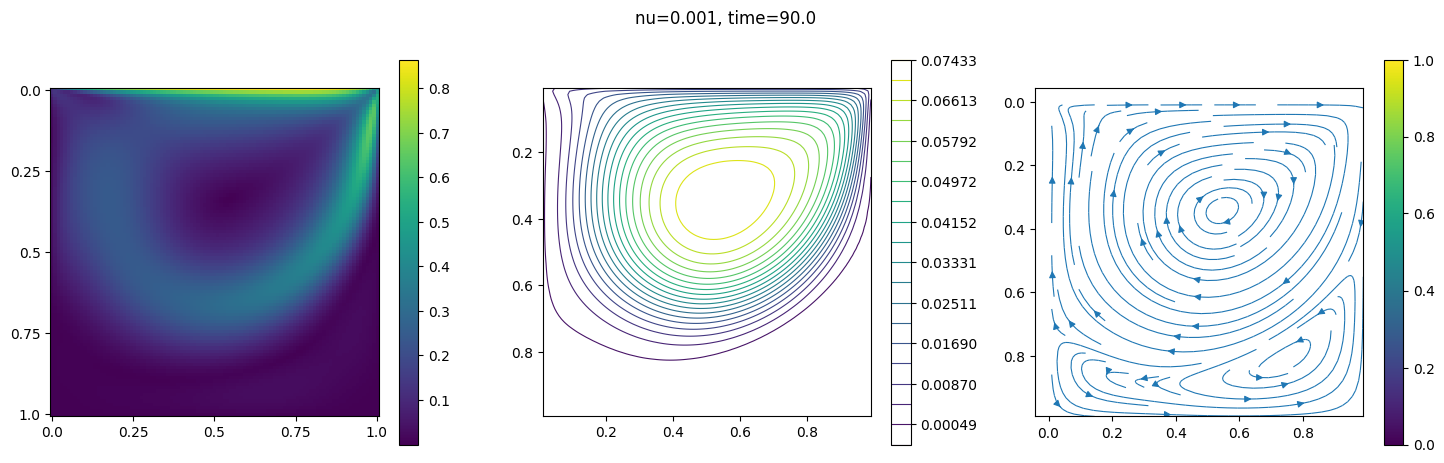

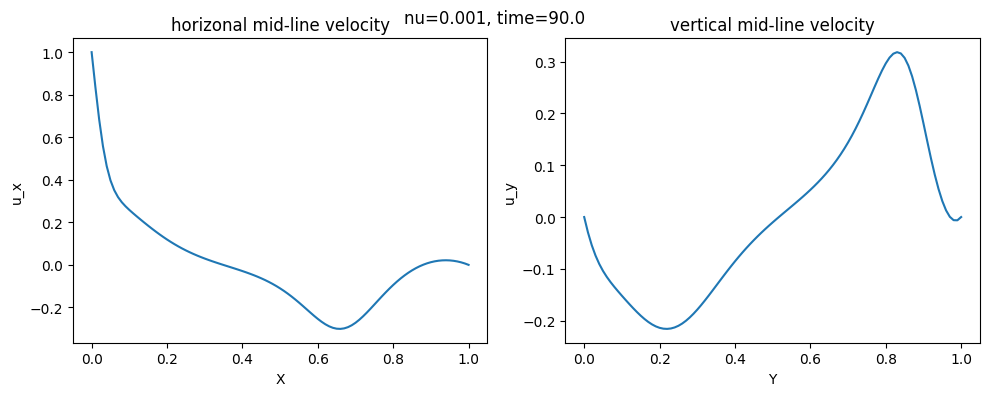

10000


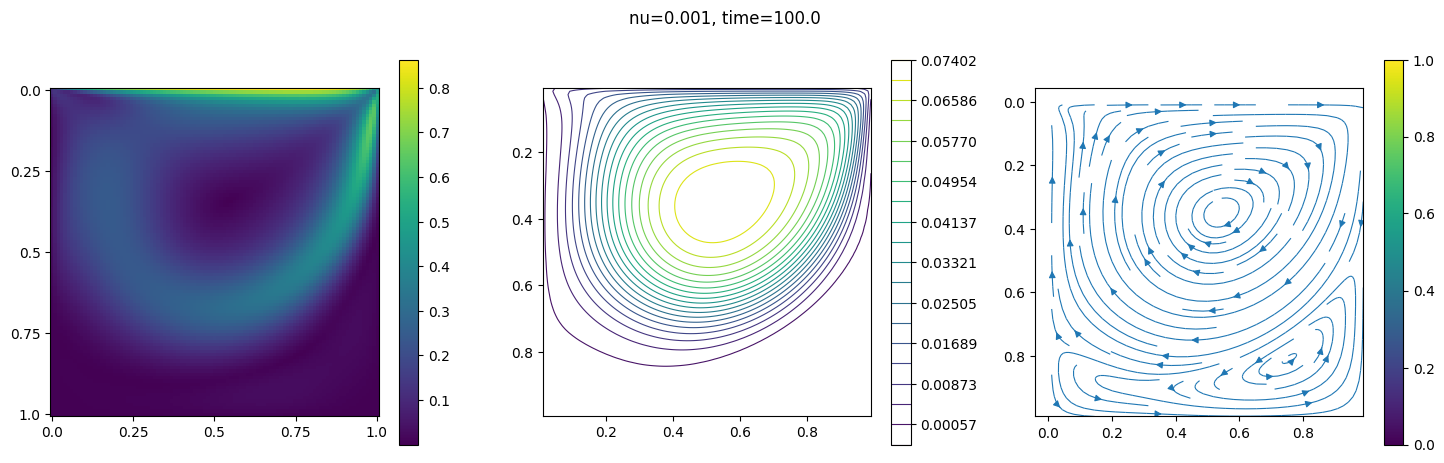

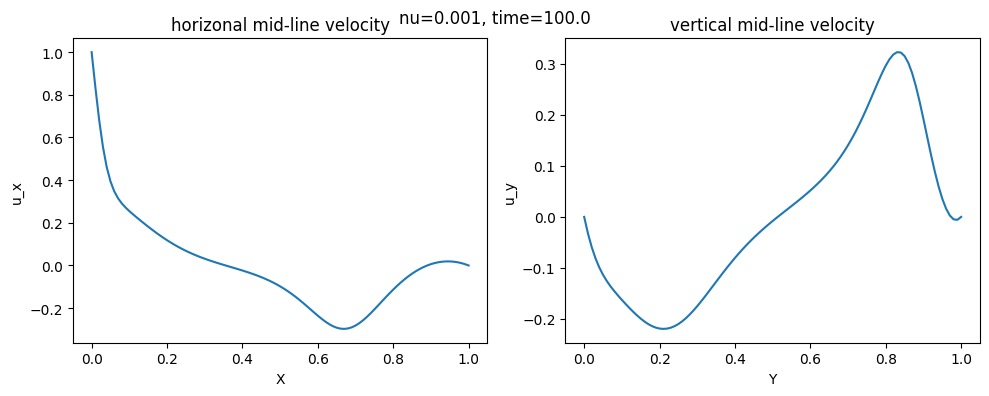

11000


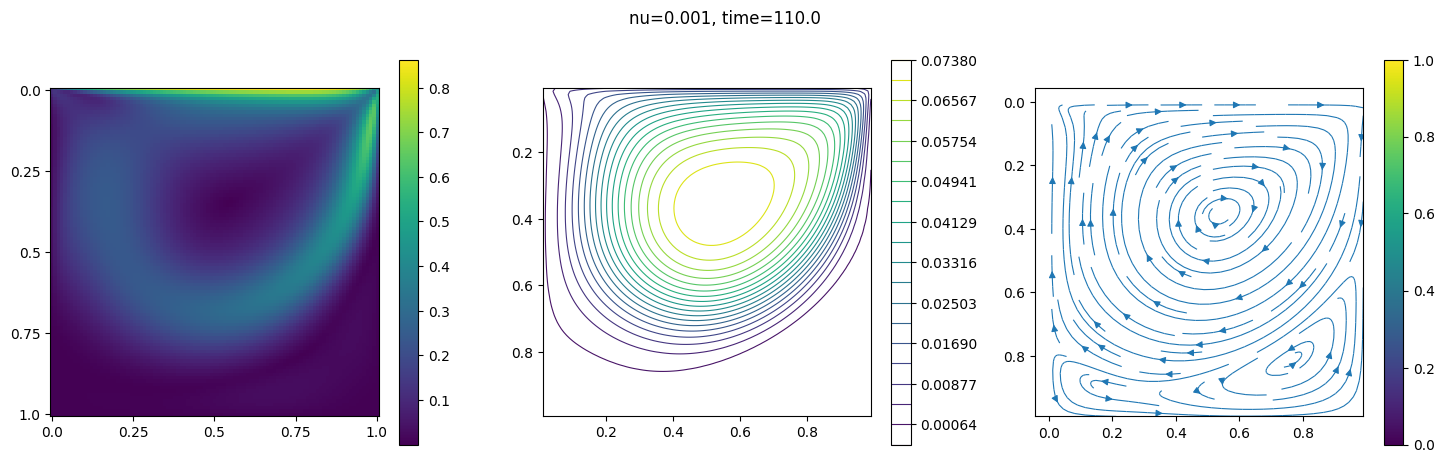

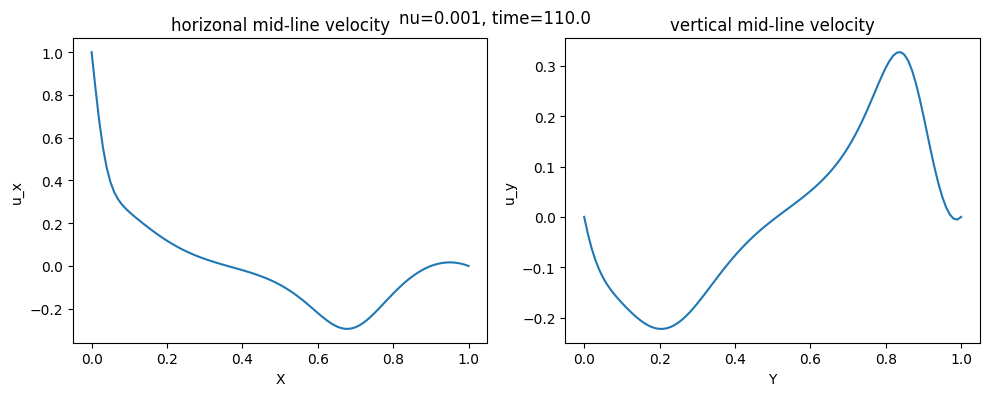

12000


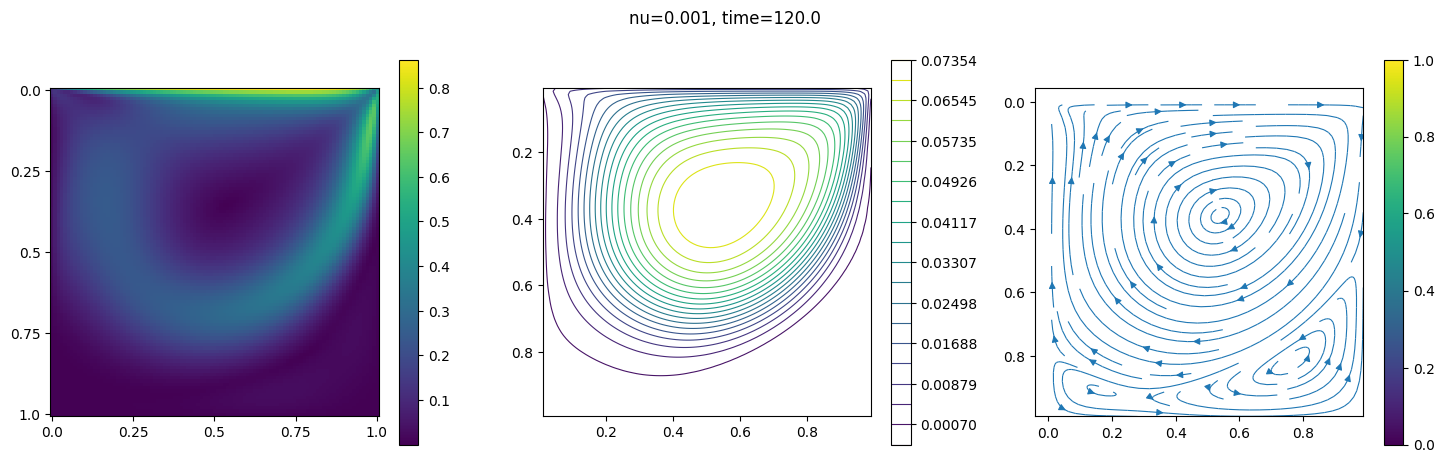

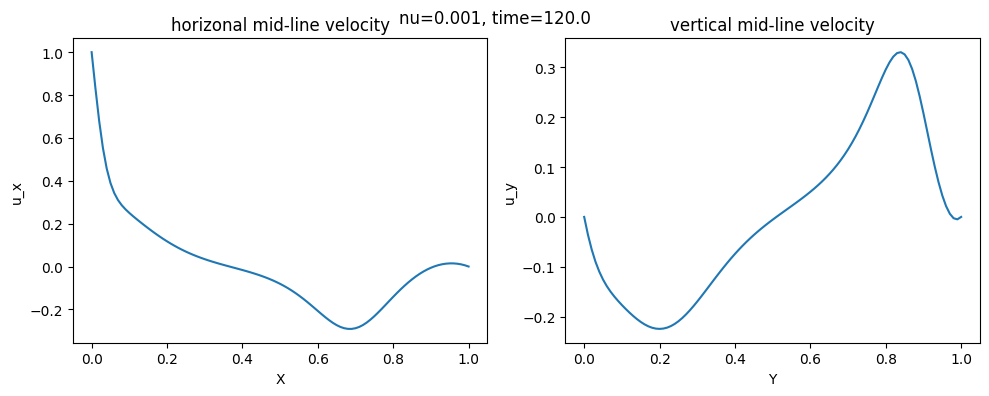

13000


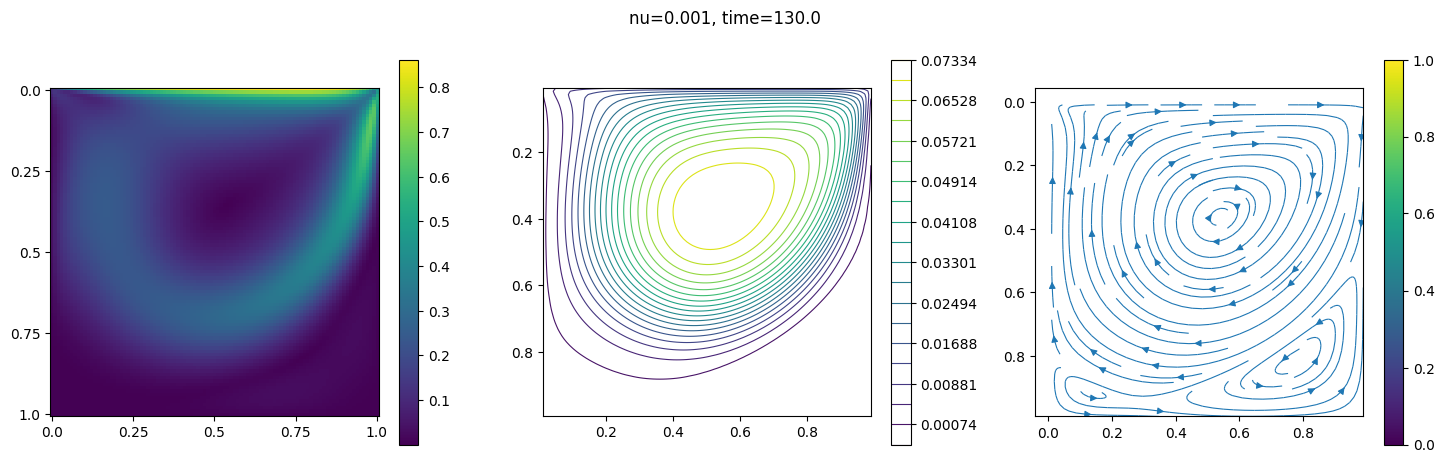

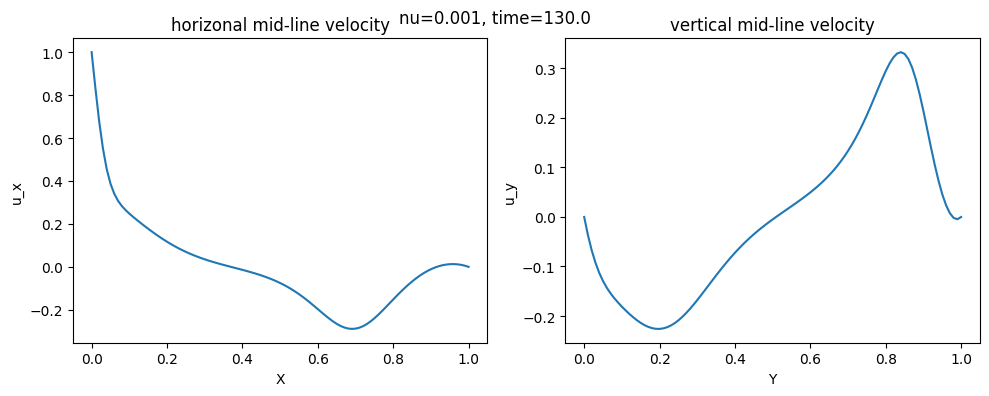

14000


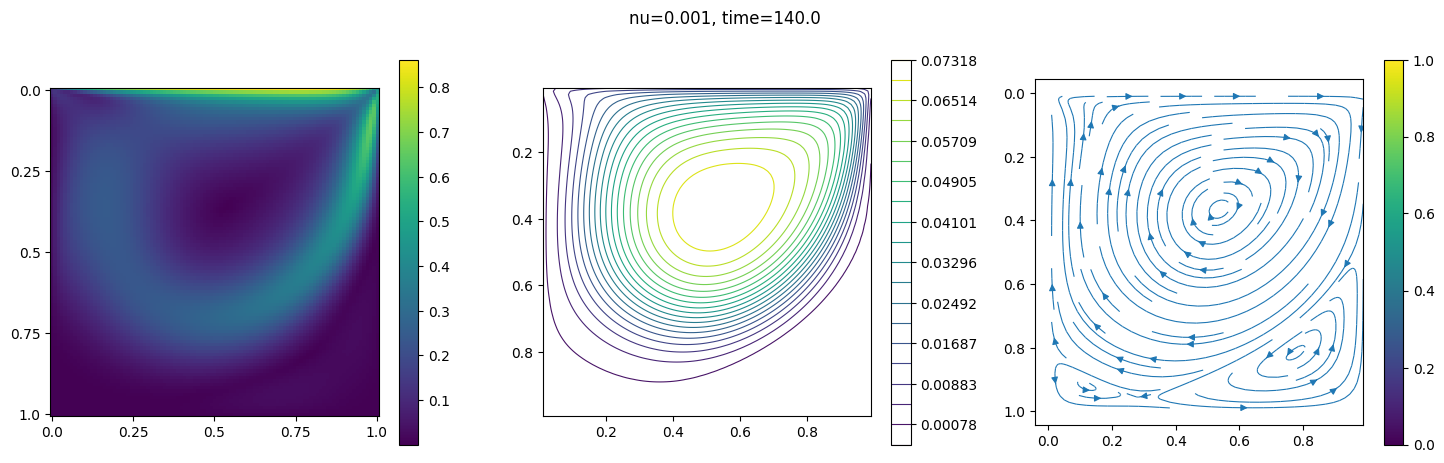

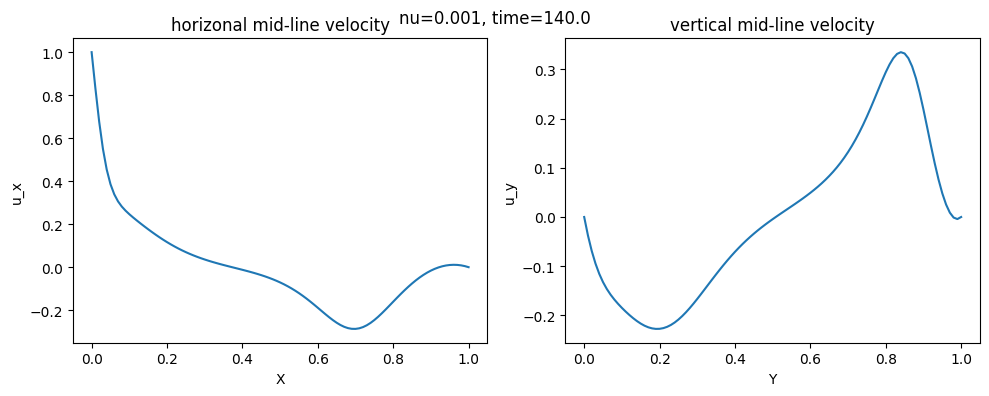

15000


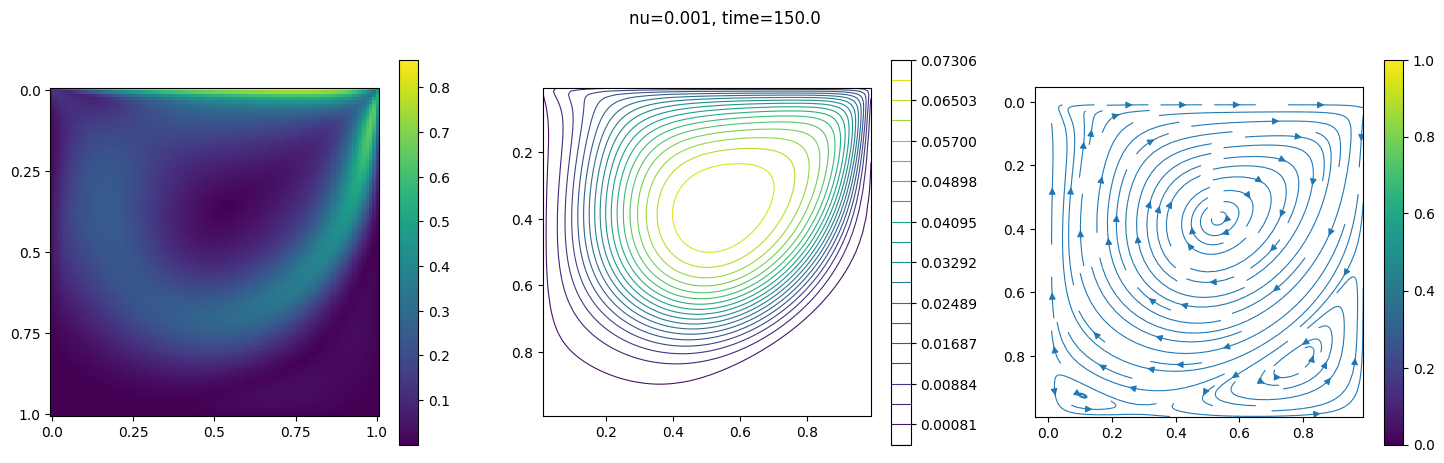

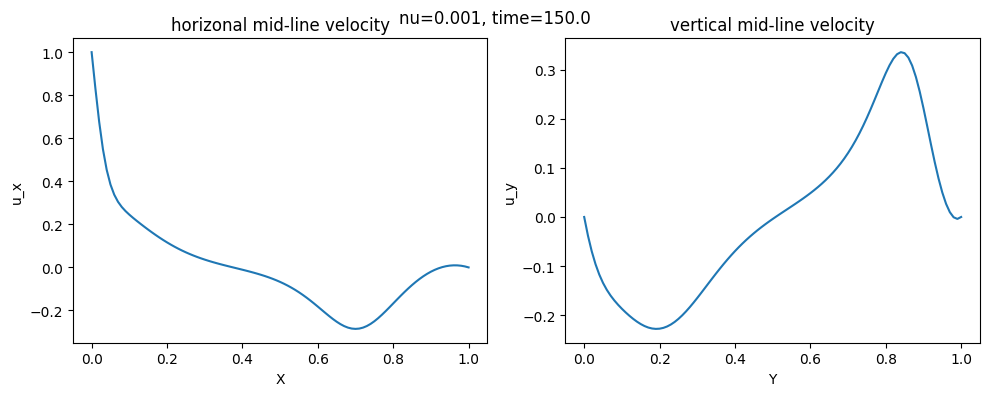

16000


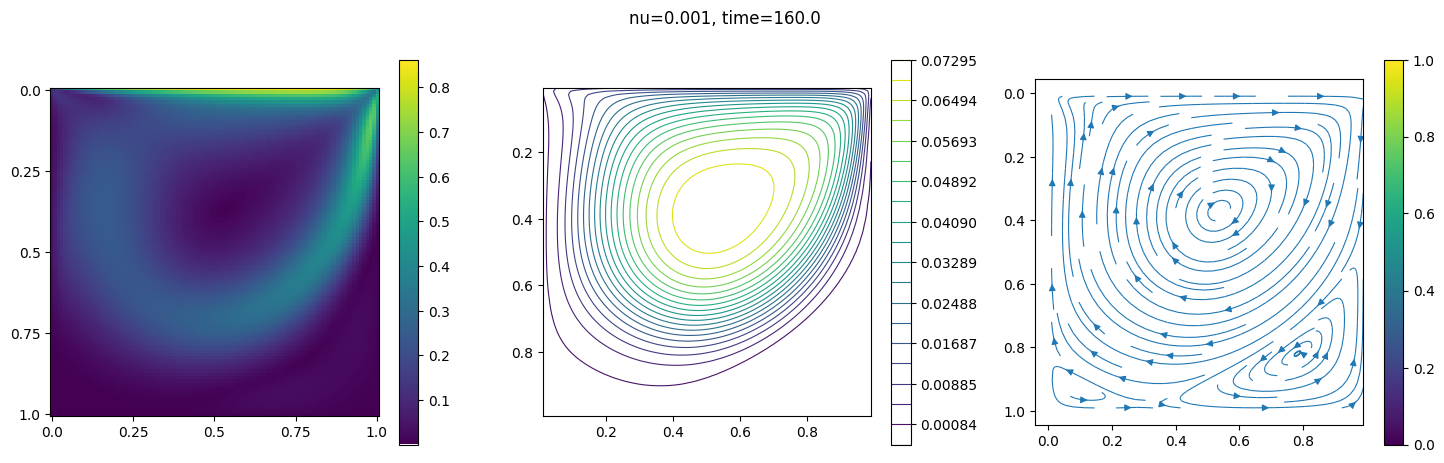

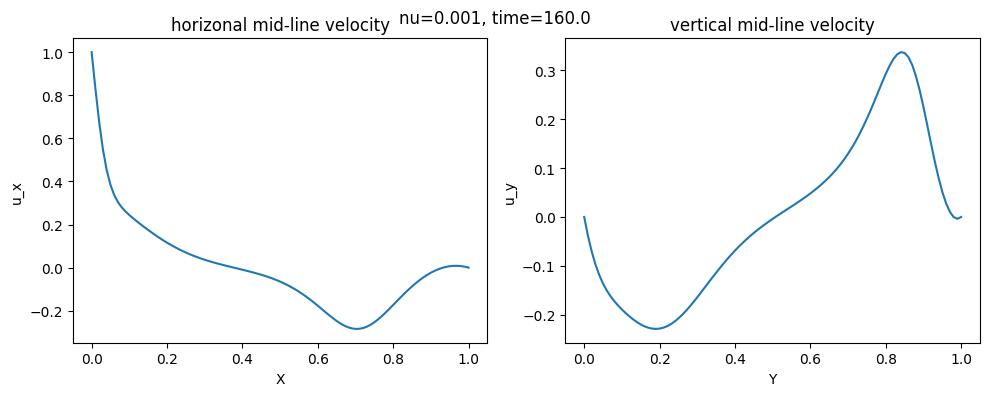

17000


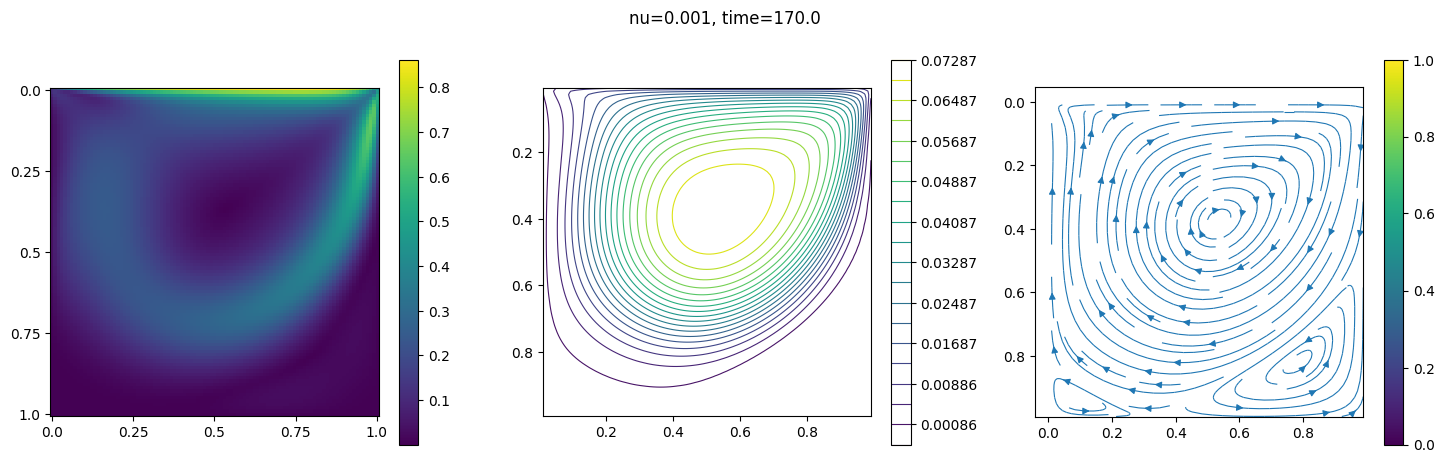

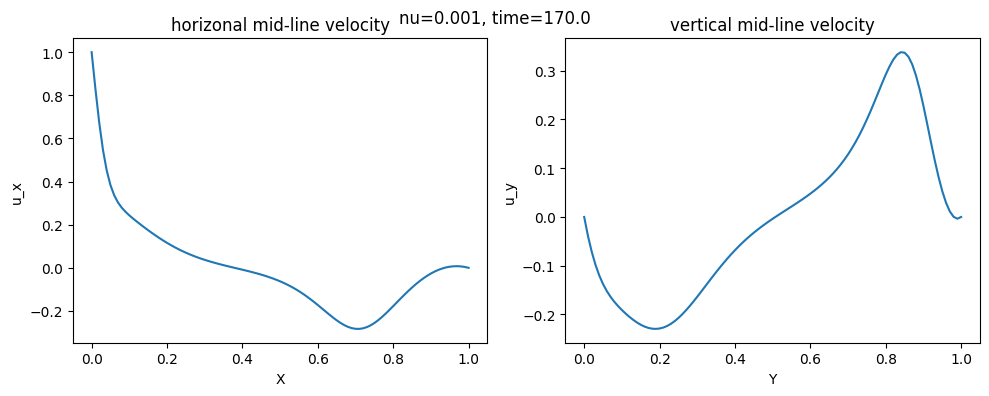

18000


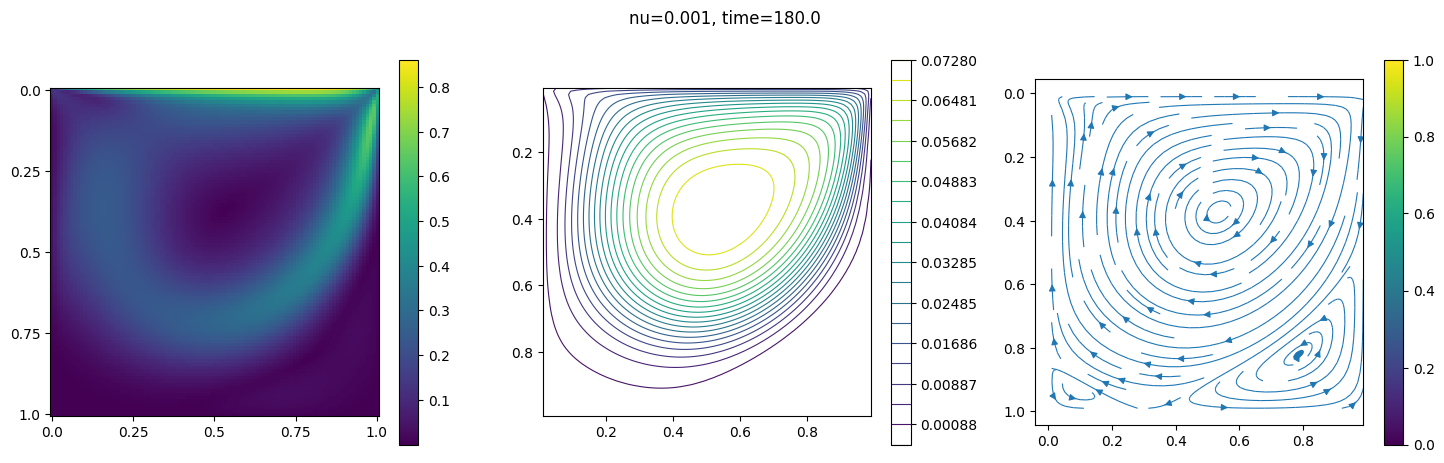

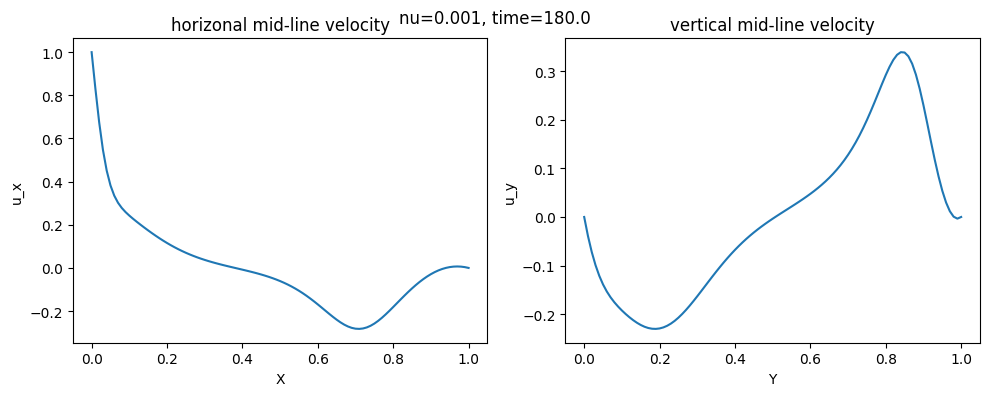

19000


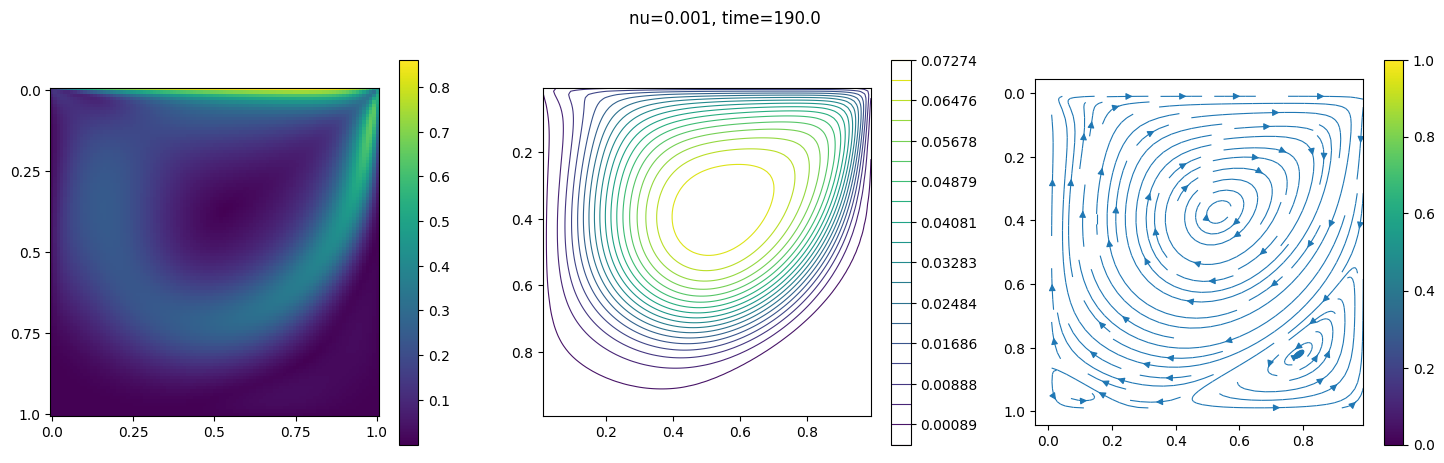

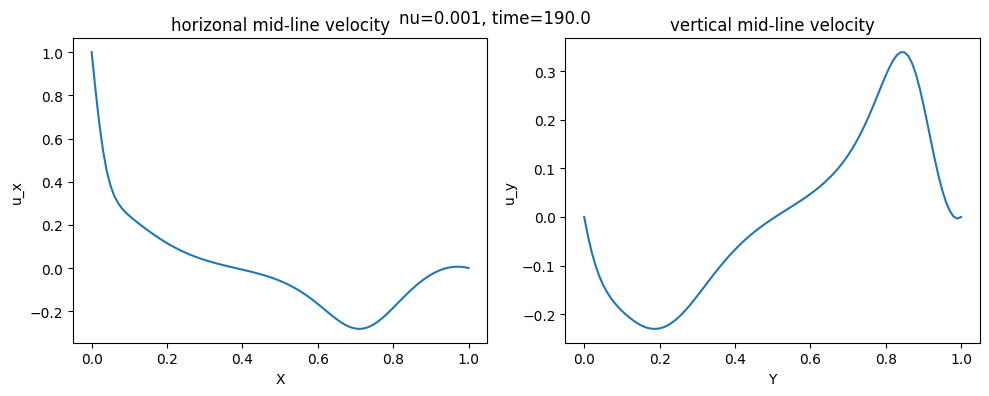

20000


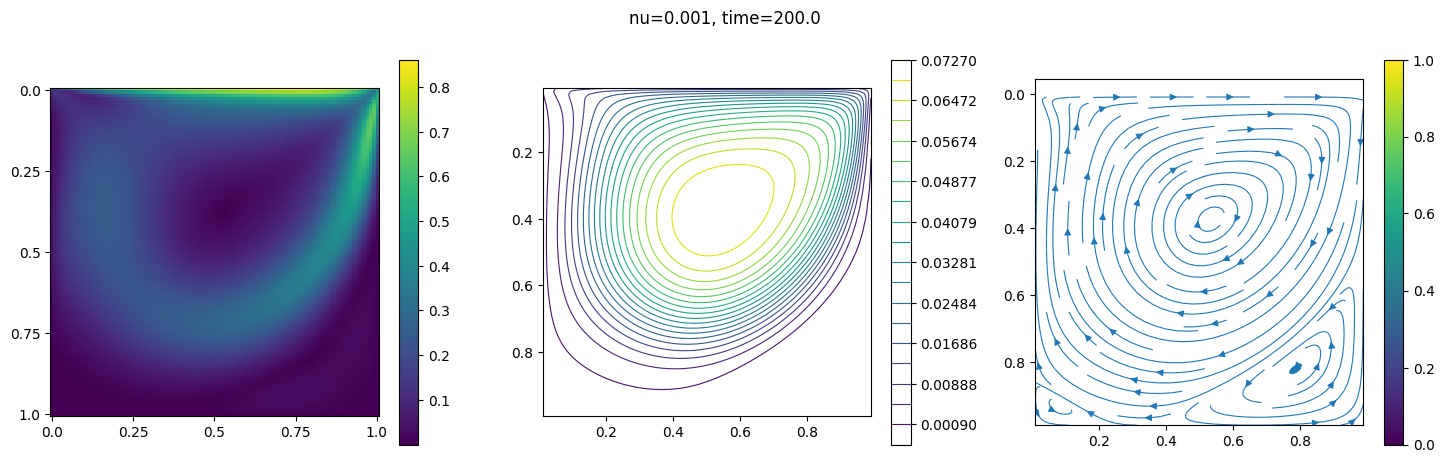

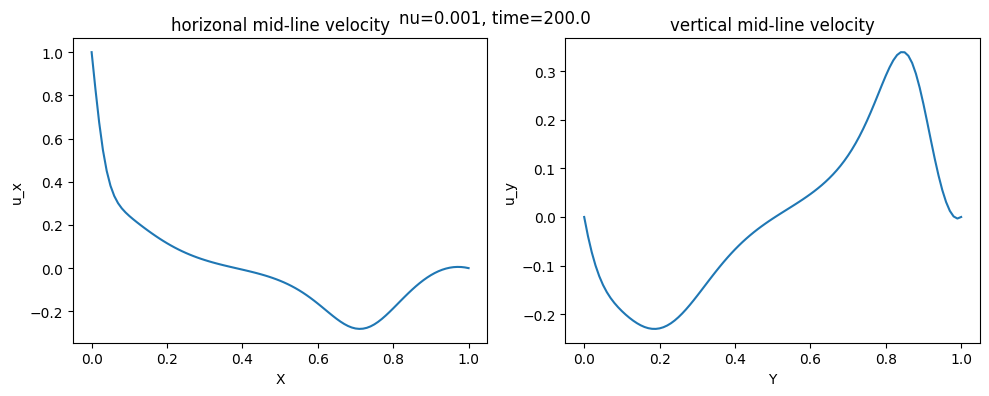

In [2]:
# 边界划分为100份，共101个点
Nx = 101
Ny = 101
Lx = Ly = 1
x = np.linspace(0, Lx, Nx)
dx = x[-1] - x[-2]
y = np.linspace(0, Ly, Ny)
dy = y[-1] - y[-2]
nu = 0.001
dt = 0.01

xx, yy = np.meshgrid(x, y)

u_b = np.zeros_like(xx)
v_b = np.zeros_like(yy)
# u_b[0, :] = 16 * x ** 2 * (1.0 - x) ** 2
u_b[0, :] = 1.0
uxx_b = np.zeros_like(xx)
uxx_b[0, :] = 32 * (6 * x**2 - 6 * x + 1)

# 更新初始条件

w_0 = v_to_w(u_b, v_b, dx, dy)
psi_0 = w_to_phi(w_0, dx, dy, 1e-4)
w_0 = boundary_w(w_0, u_b, v_b, psi_0, dx, dy)

w = w_0.copy()
psi = psi_0.copy()

N_step = 20000

# 开始迭代！
for iter in range(1, N_step+1):
    w = boundary_w(w, u_b, v_b, psi, dx, dy)
    w = next_w(w, psi, dx, dy, dt, nu)
    psi = w_to_phi(w, dx, dy, 1e-4)
    if iter % 1000 == 0:
        print(iter)
        velo_x, velo_y, velo = psi_to_v(psi, u_b, v_b, dx, dy)
        paint(velo_x[1:-1, 1:-1], velo_y[1:-1, 1:-1], velo[1:-1, 1:-1], psi[1:-1, 1:-1], xx[1:-1, 1:-1],
              yy[1:-1, 1:-1], f"nu={nu}, time={iter*dt}")
        paint_velo(velo_x, velo_y, f"nu={nu}, time={iter*dt}")